In [ ]:
!pip install python-terrier datasets scikit-learn gensim sentence-transformers

In [ ]:
import warnings
# Ingorar warnings de tipo DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Dense Retrieval Word2vec

In [ ]:
import gensim.downloader as api
model = api.load('word2vec-google-news-300')

In [ ]:
from google.colab import drive
import pyterrier as pt
import ir_datasets
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from gensim.utils import simple_preprocess
import numpy as np
import pickle

In [ ]:
# descargar la coleccion trec vaswani
dataset = ir_datasets.load("vaswani")


In [ ]:
# metodo para convertir texto a vectores, incluye preprocesamiento
def text_avg_vect(text):
  word_vect = []
  not_found_words = []
  for term in simple_preprocess(text):
      try:
        word_vect.append(model.get_vector(term))
      except KeyError:
        not_found_words.append(term)

  return np.mean(word_vect, axis=0)

In [ ]:

# Calcular el vector promedio de los vectors de todas las palabras
#docs_vec = {}
## guardar palabras no encontradas para hacer un analisis posterior
#not_found_words = []
#
#for doc_id, text in dataset.docs_iter():
#  docs_vec[doc_id] = text_avg_vect(text)
#
#
#
#drive.mount('/content/drive/')
#word2vec_vaswani_file = '/content/drive/My Drive/embeddings/word2vec_vaswani.pkl'
#
#with open(word2vec_vaswani_file, 'wb') as file:
#    pickle.dump(docs_vec, file)
#file.close()


In [ ]:
# Para reducir los tiempos de procesamiento la media de los vectores es precomputados
drive.mount('/content/drive/')
word2vec_vaswani_file = '/content/drive/My Drive/embeddings/word2vec_vaswani.pkl'


with open(word2vec_vaswani_file, 'rb') as file:
    docs_vec = pickle.load(file)
file.close()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# En esta celda se realiza un cambio de estructura al dataset vaswani

from sklearn.metrics.pairwise import cosine_similarity
import time

#  Convertir dataset de documentos a formato apropiado para indexación
dataset = ir_datasets.load("vaswani")
corpus = [{"docno": doc.doc_id, "text": doc.text} for doc in dataset.docs_iter()]

# Convertir querie a Pandas DataFrame
topics = dataset.queries_iter()
topics_df = pd.DataFrame([(query.query_id, query.text) for query in topics], columns=["qid", "query"])

# Convertir qrels a Pandas dataframe
qrels = dataset.qrels_iter()
qrels_df = pd.DataFrame([(qrel.query_id, qrel.doc_id, qrel.relevance) for qrel in qrels], columns=["qid", "docno", "label"])


# Inicializar pyterrier
if not pt.started():
    pt.init()


# Definir un modelo custom pyterrier
class Word2VecBasedModel(pt.transformer.Transformer):
    def __init__(self, docs_vec):
        super().__init__()
        self.docs_vec = docs_vec
        self.doc_ids = None
        self.start_time = None
        self.end_time = None

    def index(self, corpus):
        documents = [doc["text"] for doc in corpus]
        self.doc_ids = [doc["docno"] for doc in corpus]

    # medir tiempos de ejecución
    def get_execution_time(self):
      execution_time = self.end_time - self.start_time
      return execution_time

    def transform(self, topics):
        self.start_time = time.time()
        results = []
        # Iterar queries
        for topic in topics.itertuples(index=False):
            query = topic.query
            query_avg_vector = text_avg_vect(query).reshape(1, -1)

            for doc_index, doc_id in enumerate(self.doc_ids):
              if not np.isnan(self.docs_vec[doc_id]).all():
                # calcular similitud entre el vector de la query y el documento
                score = cosine_similarity(query_avg_vector, self.docs_vec[doc_id].reshape(1, -1))
                results.append([int(topic.qid), int(doc_id), float(score)])
        dataframe = pd.DataFrame(results, columns=["qid", "docno", "score"])
        # Orderar resultados en base al query id, luego en base al score
        self.end_time = time.time()
        return dataframe.sort_values(by=['qid', 'score'], ascending=[True, False])

custom_model = Word2VecBasedModel(docs_vec)

# Index the documents
custom_model.index(corpus)

# Create a retrieval pipeline with the custom model
word2vec_pipeline = custom_model

In [ ]:
dataset = pt.get_dataset("vaswani")
start_time = time.time()
bm25 = pt.BatchRetrieve.from_dataset(dataset, "terrier_stemmed", wmodel="BM25")
bm25_results = pt.Experiment([bm25], topics_df, qrels_df,
              eval_metrics=["map", "ndcg", "recip_rank", "recall"],
              names=['bm25'])
end_time = time.time()
bm25_execution_time = end_time - start_time

word2vec_results = pt.Experiment([word2vec_pipeline], topics_df, qrels_df,
              eval_metrics=["map", "ndcg", "recip_rank", "recall"],
              names=['word2vec'])


In [ ]:
pd.concat([bm25_results, word2vec_results])

,name,map,ndcg,recip_rank,R@5,R@10,R@15,R@20,R@30,R@100,R@200,R@500,R@1000
0,bm25,0.296519,0.621200,0.725665,0.162592,0.218513,0.260196,0.300136,0.374032,0.599046,0.732080,0.867562,0.934607
0,word2vec,0.137122,0.482222,0.475176,0.090013,0.124560,0.151985,0.185011,0.220794,0.377135,0.504518,0.651954,0.761991


# Dense Retrieval SentenceBert

In [ ]:
# calcular vectores de los documentos y almacenarlos
sentencebert_vaswani_file = '/content/drive/My Drive/embeddings/sentence_bert_vaswani.pkl'

# código comentado para evitar su ejecución en prueba
#for doc_id, article_text in zip(vaswani_docs['doc_id'], vaswani_docs['text']):
#  sentence_vector = modelo.encode(article_text , convert_to_tensor=True)
#  docs_vec[doc_id] = sentence_vector
#
#
#with open(sentencebert_vaswani_file, 'wb') as file:
#    pickle.dump(docs_vec, file)
#file.close()

In [ ]:
from sentence_transformers import SentenceTransformer
# descargar modelo sentence-transformers
sentence_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Dense Retrieval SentenceBert

In [ ]:
# calcular vectores de los documentos y almacenarlos
sentencebert_vaswani_file = '/content/drive/My Drive/embeddings/sentence_bert_vaswani_MiniLM.pkl'

# código comentado para evitar su ejecución en prueba
#for record in corpus:
#  sentence_vector = sentence_model.encode( record['text'] , convert_to_tensor=True)
#  docs_vec[record['docno']] = sentence_vector
#
#
#with open(sentencebert_vaswani_file, 'wb') as file:
#    pickle.dump(docs_vec, file)
#file.close()

# SenteDense Retrieval SentenceBert

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import warnings

# descargar vectores pre-calculados de los documentos
with open(sentencebert_vaswani_file, 'rb') as file:
    sentencerbert_vec = pickle.load(file)
file.close()


# Definición de modelo custom
class SentenceBertModel(pt.transformer.Transformer):
    def __init__(self, docs_vec):
        super().__init__()
        self.docs_vec = docs_vec
        self.doc_ids = None
        self.start_time = None
        self.end_time = None

    def index(self, corpus):
        documents = [doc["text"] for doc in corpus]
        self.doc_ids = [doc["docno"] for doc in corpus]

    def get_execution_time(self):
      execution_time = self.end_time - self.start_time
      return execution_time

    def transform(self, topics):
        results = []
        self.start_time = time.time()

        # iterar queries
        for topic in topics.itertuples(index=False):
            query = topic.query
            query_vector = sentence_model.encode(query, convert_to_tensor=True).reshape(1, -1)
            for doc_index, doc_id in enumerate(self.doc_ids):
              # calcular similitud entre el vector de la query y el documento
              #cosine_similarity = np.dot(query_vector, self.docs_vec[doc_id]) / (np.linalg.norm(query_vector) * np.linalg.norm(self.docs_vec[doc_id]))
              score = float(cosine_similarity(query_vector, self.docs_vec[doc_id].reshape(1, -1)))
              if score:
                results.append([int(topic.qid), int(doc_id), score])
        dataframe = pd.DataFrame(results, columns=["qid", "docno", "score"])
        self.end_time = time.time()

        # Orderar resultados en base al query id, luego en base al score
        return dataframe.sort_values(by=['qid', 'score'], ascending=[True, False])


sentence_bert_model = SentenceBertModel(sentencerbert_vec)

# Indexar documentos
sentence_bert_model.index(corpus)

# Crear un retrival pipeline a partir del modelo custom
sentence_bert_pipeline = sentence_bert_model


results_sentence_bert = pt.Experiment([sentence_bert_pipeline],
    topics_df,
    qrels_df,
    eval_metrics=["map", "ndcg", "recip_rank", "recall"],
    names=['SentenceBert']
)
pd.concat([bm25_results, word2vec_results, results_sentence_bert])

,name,map,ndcg,recip_rank,R@5,R@10,R@15,R@20,R@30,R@100,R@200,R@500,R@1000
0,bm25,0.296519,0.621200,0.725665,0.162592,0.218513,0.260196,0.300136,0.374032,0.599046,0.732080,0.867562,0.934607
0,word2vec,0.137122,0.482222,0.475176,0.090013,0.124560,0.151985,0.185011,0.220794,0.377135,0.504518,0.651954,0.761991
0,SentenceBert,0.177346,0.526737,0.528032,0.093563,0.164038,0.198612,0.233244,0.277590,0.476905,0.611237,0.765009,0.864726


# SentenceBert with IVFFLAT

In [ ]:
def normalize_L2(arr):
    # Computar normalizacion L2
    l2_norm = np.linalg.norm(arr, ord=2)

    # Evitar division por cero
    if l2_norm == 0:
        return arr

    # Dividir cada elemento por la norma
    normalized_arr = arr / l2_norm

    return normalized_arr

In [ ]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 25.2 MB/s eta 0:00:00


In [ ]:
import math
import faiss

# Definición de modelo custom
class SentenceBertModelIVFF(pt.transformer.Transformer):
    def __init__(self, docs_vec):
        super().__init__()
        self.docs_vec = docs_vec
        self.doc_ids = None
        self.start_time = None
        self.end_time = None

    def index(self, corpus):
        documents = [doc["text"] for doc in corpus]
        self.doc_ids = [doc["docno"] for doc in corpus]


    def get_execution_time(self):
      execution_time = self.end_time - self.start_time
      return execution_time

    def transform(self, topics):
        # Definimos dimensiones de forma dinamica .Definición de cantidad de clusters https://github.com/facebookresearch/faiss/wiki/Guidelines-to-choose-an-index
        clusters = int(math.sqrt(len(sentencerbert_vec)) * 4)
        self.start_time = time.time()

        # convertir vectores de documentos a matriz (2d numpy array)
        vectors_matrix = np.array(list(sentencerbert_vec.values()))
        # normalizacion de vectores
        faiss.normalize_L2(vectors_matrix)

        quantizer = faiss.IndexFlatIP(vectors_matrix.shape[1])  # Como se almacenan los vectores
        index = faiss.IndexIVFFlat(quantizer, vectors_matrix.shape[1], clusters, faiss.METRIC_INNER_PRODUCT)
        index.train(vectors_matrix)  # creación de celdas
        index.add(vectors_matrix)

        index.nprobe = 19  # Cantidad de celdas vecinas en las cuales buscar
        k = 300 # vecinos

        # iterar queries
        results = []
        for topic in topics.itertuples(index=False):
            query = topic.query
            query_vector = sentence_model.encode(query).reshape(1, -1)
            faiss.normalize_L2(query_vector)
            D, I = index.search(query_vector, k)
            for doc_index, distance in zip(I.flatten(),D.flatten()):
              results.append([int(topic.qid), doc_index+1, distance])
        dataframe = pd.DataFrame(results, columns=["qid", "docno", "score"])

        self.end_time = time.time()
        # Orderar resultados en base al query id, luego en base al score
        return dataframe.sort_values(by=['qid', 'score'], ascending=[True, True])


sentence_bert_model_ivff = SentenceBertModelIVFF(sentencerbert_vec)

# Index the documents
sentence_bert_model_ivff.index(corpus)

# Create a retrieval pipeline with the custom model
sentence_bert_pipeline_ivff = sentence_bert_model_ivff


results_sentence_bert_ivff = pt.Experiment([sentence_bert_model_ivff],
    topics_df,
    qrels_df,
    eval_metrics=["map", "ndcg", "recip_rank", "recall"],
    names=['Sentence Bert inverted Flat index']
)

pd.concat([bm25_results, word2vec_results, results_sentence_bert, results_sentence_bert_ivff])

,name,map,ndcg,recip_rank,R@5,R@10,R@15,R@20,R@30,R@100,R@200,R@500,R@1000
0,bm25,0.296519,0.621200,0.725665,0.162592,0.218513,0.260196,0.300136,0.374032,0.599046,0.732080,0.867562,0.934607
0,word2vec,0.137122,0.482222,0.475176,0.090013,0.124560,0.151985,0.185011,0.220794,0.377135,0.504518,0.651954,0.761991
0,SentenceBert,0.177346,0.526737,0.528032,0.093563,0.164038,0.198612,0.233244,0.277590,0.476905,0.611237,0.765009,0.864726
0,Sentence Bert inverted Flat index,0.161675,0.410722,0.526348,0.093769,0.159392,0.202552,0.228400,0.278831,0.463789,0.567936,0.622619,0.622619


# Tiempo de búsqueda vs Recall
Selección de los parametros:
  - nprobe (clusters donde buscar)
  - nlist (clusters a crear)

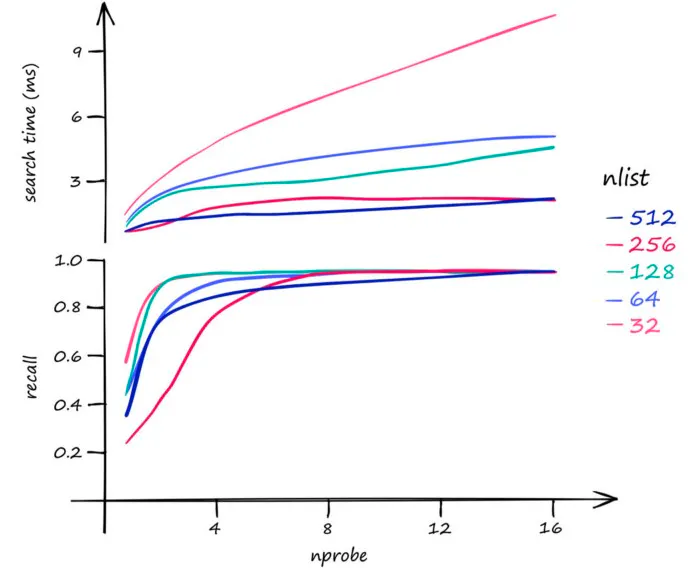

https://www.pinecone.io/learn/series/faiss/vector-indexes/#Inverted-File-Index

In [ ]:
data = {
    "Modelos": ["BM25", "Word2Vec", "SentenceBert", "SentenceBert IVFflat (búsqueda aproximada)"],
    "Tiempo de ejecución (segundos)": [ bm25_execution_time, word2vec_pipeline.get_execution_time(),
                                       sentence_bert_pipeline.get_execution_time(),
                                       sentence_bert_pipeline_ivff.get_execution_time()]
}

pd.DataFrame(data)

,Modelos,Tiempo de ejecución (segundos)
0,BM25,4.483894
1,Word2Vec,395.585682
2,SentenceBert,409.691766
3,SentenceBert IVFflat (búsqueda aproximada),3.962195
